 # 网格嵌入（Grid Embeddings）详解



 网格嵌入在神经算子（Neural Operators）中对空间坐标进行编码，帮助模型理解几何结构。

 本教程演示以下内容：

 - 2D和N维网格嵌入的使用方法

 - 自定义坐标系的配置

 - 适用于不同领域的多种嵌入类型



 网格嵌入是求解偏微分方程（PDE）、计算机视觉和其他空间结构化问题的关键技术，它为神经算子补充了坐标信息，帮助模型学习空间关系。

 ## 导入依赖库

 导入使用网格嵌入所需的核心模块

In [2]:
import random  # 随机数模块（本示例未直接使用，为通用导入）
import matplotlib.pyplot as plt  # 可视化库，用于绘制网格坐标和嵌入结果
import torch  # PyTorch核心库，用于张量运算
device = "cpu"  # 设置计算设备为CPU（本示例无需GPU加速）

 ## 理解网格嵌入的基础用法

 正如`small_darcy_vis`示例所示，我们在将数据输入FNO（傅里叶神经算子）之前， 会对数据应用2D网格位置编码。这种嵌入通过为神经算子提供空间上下文信息，已被证明能提升模型在各类应用中的性能。

 我们先从生成网格中每个像素左下角坐标的函数开始讲解：

尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages
尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages


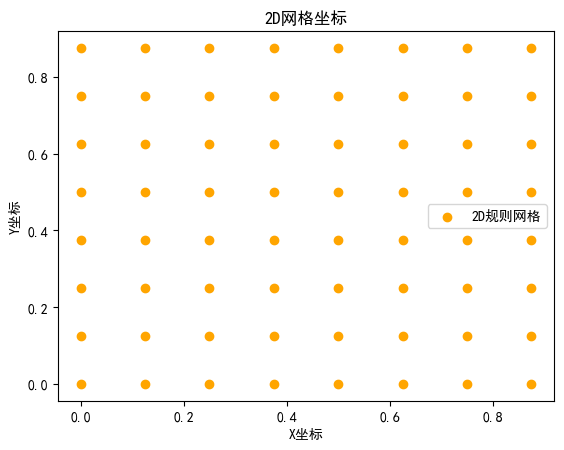

In [3]:
# 从neuralop库导入2D规则网格生成函数
from neuralop.layers.embeddings import regular_grid_2d

# 生成8x8的2D规则网格坐标，并调整张量形状
# 1. regular_grid_2d(spatial_dims=(8,8)): 在[0,1]×[0,1]中生成8x8网格的x/y坐标，返回两个(8,8)的张量
# 2. torch.stack(): 将x/y坐标张量堆叠，得到(2,8,8)的张量
# 3. permute(1,2,0): 维度重排，将(2,8,8)转为(8,8,2)（便于后续展平）
# 4. view(-1,2): 展平为(64,2)的张量（64=8*8，每个元素是一个坐标点(x,y)），这里-1表示自动计算该维度大小
grid_2d = (
    torch.stack(regular_grid_2d(spatial_dims=(8, 8))).permute(1, 2, 0).view(-1, 2)
)  
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
# 可视化2D网格坐标点
plt.scatter(grid_2d[:, 0], grid_2d[:, 1], color="orange", label="2D规则网格")  # 绘制所有坐标点
plt.legend()  # 显示图例
plt.title("2D网格坐标")  # 设置标题
plt.xlabel("X坐标")  # X轴标签
plt.ylabel("Y坐标")  # Y轴标签
plt.show()  # 显示图像


 ## 将网格嵌入应用到实际数据

 在实际应用中，我们会将代表每个像素x/y坐标的两个通道，拼接到PDE问题中编码物理变量的通道之后。这为神经算子提供了关键的空间上下文信息。

In [ ]:
# 导入Darcy Flow数据集加载函数和2D网格嵌入类
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.layers.embeddings import GridEmbedding2D

# 加载Darcy-Flow数据集用于演示
# 参数说明：
# - n_train: 训练集样本数（10个）
# - batch_size: 训练批次大小（1）
# - test_resolutions: 测试集分辨率列表（16x16和32x32）
# - n_tests: 各分辨率测试集样本数（各16个）
# - test_batch_sizes: 各分辨率测试批次大小（各2个）
# - encode_output: 是否编码输出（False表示不编码）
_, test_loaders, _ = load_darcy_flow_small(
    n_train=10,
    batch_size=1,
    test_resolutions=[16, 32],
    n_tests=[16, 16],
    test_batch_sizes=[2, 2],
    encode_output=False,
)

# 获取16x16分辨率的测试数据加载器
loader_16 = test_loaders[16]
# 从数据加载器中获取一个批次的样本
example = next(iter(loader_16))
x = example["x"]  # 提取输入数据（Darcy Flow的渗透率场）
print(f"输入数据x的形状: {x.shape}")  # 输出形状：torch.Size([2, 1, 16, 16]) 
                                     # 解释：2（批次大小）、1（通道数）、16x16（空间分辨率）

# 注意：Darcy数据集生成在单位正方形[0,1]x[0,1]上，网格嵌入的边界是可配置的
# 初始化2D网格嵌入层
# 参数说明：
# - in_channels: 输入通道数（1，对应Darcy数据的渗透率场通道）
# - grid_boundaries: 网格边界，[[0,1],[0,1]]表示x/y轴都在0到1之间
grid_embedding = GridEmbedding2D(in_channels=1, grid_boundaries=[[0, 1], [0, 1]])

# 对输入数据应用网格嵌入
# 作用：在原有1个通道后，拼接x和y坐标的2个通道，总通道数变为3
x = grid_embedding(x)
print(f"嵌入后x的形状: {x.shape}")  # 输出形状：torch.Size([2, 3, 16, 16])
                                     # 解释：2（批次大小）、3（1原通道+2坐标通道）、16x16（分辨率）


Loading test db for resolution 16 with 16 samples 
Loading test db for resolution 32 with 16 samples 


c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


输入数据x的形状: torch.Size([2, 1, 16, 16])
嵌入后x的形状: torch.Size([2, 3, 16, 16])


 ## 可视化嵌入后的数据

 我们可以可视化网格嵌入如何为数据添加坐标信息。

 嵌入层新增了两个通道：一个用于x坐标，一个用于y坐标。

C:\Users\MR\AppData\Local\Temp\ipykernel_7256\3367794266.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # 显示图像


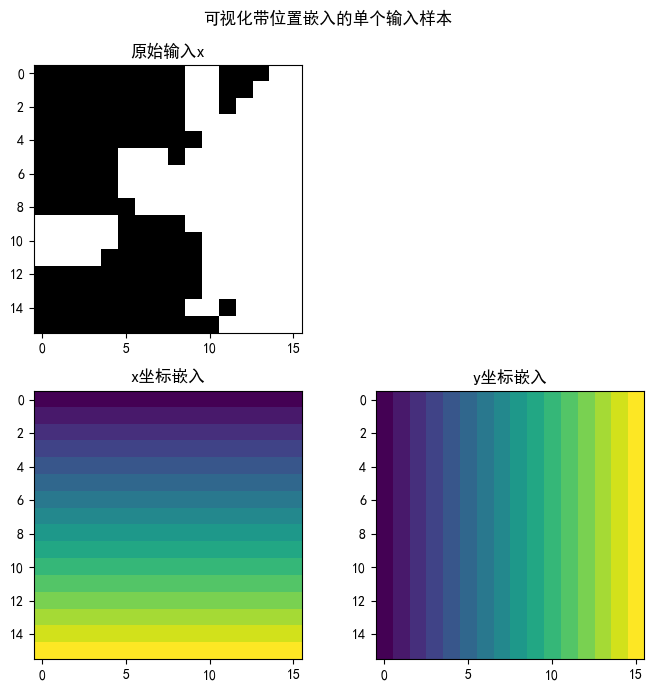

In [5]:
# 提取批次中的第一个样本（去掉批次维度）
x = x[0]
# 创建绘图画布，设置尺寸为7x7英寸
fig = plt.figure(figsize=(7, 7))
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
# 绘制原始输入数据（第0个通道：渗透率场）
ax = fig.add_subplot(2, 2, 1)  # 创建2x2子图的第1个位置
ax.imshow(x[0], cmap="gray")   # 以灰度图显示原始数据
ax.set_title("原始输入x")      # 设置子图标题

# 绘制x坐标嵌入通道（第1个通道）
ax = fig.add_subplot(2, 2, 3)  # 创建2x2子图的第3个位置
ax.imshow(x[1])                # 显示x坐标分布
ax.set_title("x坐标嵌入")       # 设置子图标题

# 绘制y坐标嵌入通道（第2个通道）
ax = fig.add_subplot(2, 2, 4)  # 创建2x2子图的第4个位置
ax.imshow(x[2])                # 显示y坐标分布
ax.set_title("y坐标嵌入")       # 设置子图标题

# 设置总标题，y=0.98调整标题位置避免重叠
fig.suptitle("可视化带位置嵌入的单个输入样本", y=0.98)
plt.tight_layout()  # 自动调整子图间距
fig.show()  # 显示图像


 ## 离散化不变性（Discretization Invariance）

 我们的嵌入层设计时考虑了离散化不变性：无需任何修改， 即可将相同的嵌入层应用到更高分辨率的数据上。 这对于需要处理不同分辨率数据的神经算子至关重要。

In [ ]:
# 获取32x32分辨率的测试数据加载器
loader_32 = test_loaders[32]
# 从数据加载器中获取一个批次的样本
example = next(iter(loader_32))
x = example["x"]  # 提取输入数据
print(f"32x32分辨率输入x的形状: {x.shape}")  # 输出形状：torch.Size([2, 1, 32, 32])

# 将同一个网格嵌入层应用到更高分辨率的数据上
x = grid_embedding(x)
print(f"嵌入后x的形状: {x.shape}")  # 输出形状：torch.Size([2, 3, 32, 32])
                                     # 解释：通道数仍为3（1原通道+2坐标通道），分辨率变为32x32


32x32分辨率输入x的形状: torch.Size([2, 1, 32, 32])
嵌入后x的形状: torch.Size([2, 3, 32, 32])


 ## 可视化更高分辨率的嵌入结果

 我们可以看到网格嵌入如何适配不同的分辨率： 坐标信息会自动调整到新的网格尺寸，保持空间关系的一致性。

C:\Users\MR\AppData\Local\Temp\ipykernel_7256\2944804821.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # 显示图像


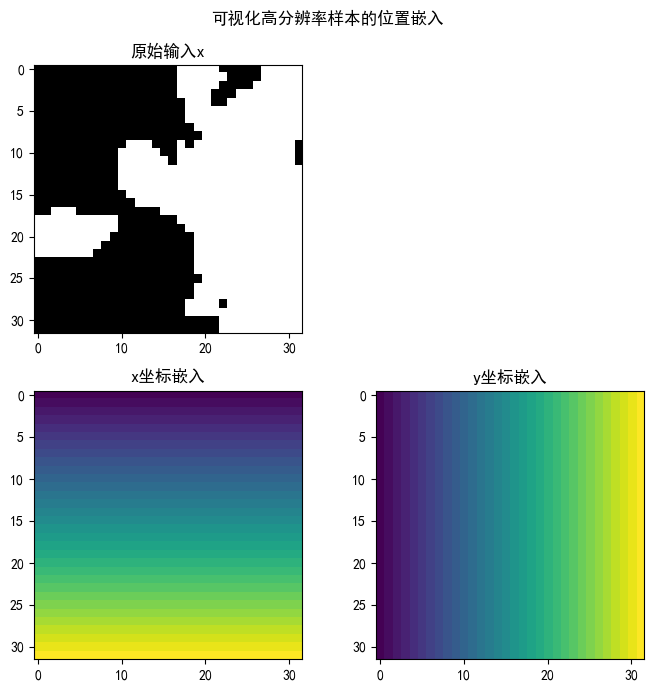

In [7]:
# 提取批次中的第一个样本（去掉批次维度）
x = x[0]
# 创建绘图画布，设置尺寸为7x7英寸
fig = plt.figure(figsize=(7, 7))

# 绘制原始输入数据（第0个通道）
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0], cmap="gray")
ax.set_title("原始输入x")

# 绘制x坐标嵌入通道（第1个通道）
ax = fig.add_subplot(2, 2, 3)
ax.imshow(x[1])
ax.set_title("x坐标嵌入")

# 绘制y坐标嵌入通道（第2个通道）
ax = fig.add_subplot(2, 2, 4)
ax.imshow(x[2])
ax.set_title("y坐标嵌入")

# 设置总标题
fig.suptitle("可视化高分辨率样本的位置嵌入", y=0.98)
plt.tight_layout()  # 自动调整子图间距
fig.show()  # 显示图像


 ## 理解离散化不变性

 网格嵌入会自动适配不同分辨率：

 1. 坐标值会归一化到相同范围，与分辨率无关

 2. 空间关系在不同网格尺寸下保持一致

 3. 这使得神经算子可以无缝处理不同分辨率的数据

 4. 同一个模型可应用于不同空间离散化精度的数据

 ## 3D网格嵌入的使用

 接下来演示如何对3D张量应用网格嵌入。

 这适用于涉及3D空间数据的问题，例如：

 - 3D流体动力学

 - 体医学成像

 - 3D材料科学问题

In [10]:
# 导入N维网格嵌入类（支持任意维度）
from neuralop.layers.embeddings import GridEmbeddingND

# 创建一个单通道的3D张量（模拟3D空间数据）
# 参数说明：cube_len=5 表示立方体的边长为5，张量形状为(1,1,5,5,5)
# 解释：1（批次）、1（通道）、5x5x5（3D空间分辨率）
cube_len = 5
x = torch.randn(1, 1, cube_len, cube_len, cube_len)

# 初始化3D网格嵌入层
# 参数说明：
# - in_channels: 输入通道数（1）
# - dim: 嵌入维度（3，表示3D）
# - grid_boundaries: 3个维度的边界，[[0,1]]*3表示x/y/z轴都在0到1之间
embedding_3d = GridEmbeddingND(in_channels=1, dim=3, grid_boundaries=[[0, 1]] * 3)

# 对3D张量应用网格嵌入
# 作用：在原有1个通道后，拼接x/y/z坐标的3个通道，总通道数变为4
x = embedding_3d(x)
print(f"嵌入后3D张量x的形状: {x.shape}")  # 输出形状：torch.Size([1, 4, 5, 5, 5])
                                           # 解释：1（批次）、4（1原通道+3坐标通道）、5x5x5（分辨率）


嵌入后3D张量x的形状: torch.Size([1, 4, 5, 5, 5])


 ## 可视化3D网格嵌入

 我们可以通过3D空间中的点来可视化3D嵌入结果，

 每个点代表一个空间位置，颜色表示其z坐标值。

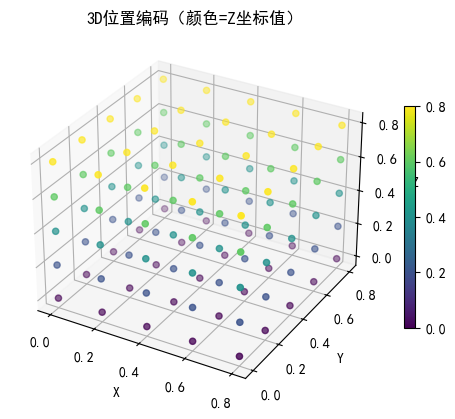

In [9]:
# 处理3D嵌入结果，便于可视化
# 步骤说明：
# 1. x[0, 1:, ...]: 取第一个样本，去掉原始通道，只保留3个坐标通道
# 2. permute(1,2,3,0): 维度重排，将(3,5,5,5)转为(5,5,5,3)
# 3. view(-1,3): 展平为(125,3)的张量（125=5*5*5，每个元素是一个3D坐标点(x,y,z)）
x = x[0, 1:, ...].permute(1, 2, 3, 0).view(-1, 3)

# 创建3D绘图画布
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# 绘制3D散点图，颜色由z坐标值决定
plot = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=x[:, 2])
# 添加颜色条（显示z值与颜色的对应关系）
fig.colorbar(plot, ax=ax, shrink=0.6)
# 设置标题和坐标轴标签
ax.set_title("3D位置编码（颜色=Z坐标值）")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
# 显示图像
plt.show()